In [ ]:
import tensorflow as tf
import numpy as np
import random, os, glob, time
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# Consolidated dark theme styling for scientific publication
sns.set_style("dark")  # Use Seaborn's dark style
plt.style.use('dark_background')

plt.rcParams.update({
    'figure.facecolor': '#222222',   # Dark figure background
    'axes.facecolor':   '#222222',     # Dark axes background
    'axes.edgecolor':   'white',       # White axes edges
    'axes.labelcolor':  'white',       # White axis labels
    'xtick.color':      'white',       # White x-tick labels
    'ytick.color':      'white',       # White y-tick labels
    'grid.color':       'white',       # Light grid lines
    'text.color':       'white',       # White text
    'legend.frameon':   False,         # No legend frame
    'font.size':        12,
    'axes.labelsize':   14,
    'axes.titlesize':   16,
    'legend.fontsize':  12,
    'xtick.labelsize':  12,
    'ytick.labelsize':  12
})

# Example usage (replace with your own plotting code):
# plt.figure(figsize=(6,4))
# plt.plot(x_values, y_values, 'o-', label='Data', color='cyan')
# plt.xlabel("X-axis Label")
# plt.ylabel("Y-axis Label")
# plt.title("Your Figure Title")
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.3)
# plt.tight_layout()
# plt.savefig("your_figure.pdf", format='pdf', dpi=300)
# plt.show()


In [2]:
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# Data and image parameters
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 224, 224, 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
TRAIN_DIR = 'data/chest_xray/chest_xray/train'
TEST_DIR  = 'data/chest_xray/chest_xray/test'
# Assume training folder has one subfolder per class (e.g., NORMAL, PNEUMONIA)
NUM_CLASSES = len([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
# For episodic (few–shot) training:
K_SHOT  = 8  # number of support images per class per episode
Q_QUERY = 8  # number of query images per class per episode

print(f"Found {NUM_CLASSES} classes in training data.")

Found 2 classes in training data.


In [3]:
def load_data_by_class(data_dir):
    """
    Loads file paths for each class into a dictionary.
    """
    data = {}
    for cls in os.listdir(data_dir):
        full_dir = os.path.join(data_dir, cls)
        if os.path.isdir(full_dir):
            files = glob.glob(os.path.join(full_dir, '*'))
            data[cls] = files
    return data

# Load training and test data by class (for episodic training)
train_data = load_data_by_class(TRAIN_DIR)
test_data  = load_data_by_class(TEST_DIR)

def generate_episode(data, num_classes=NUM_CLASSES, k_shot=K_SHOT, q_query=Q_QUERY):
    """
    Generate one episode:
      - Randomly sample 'num_classes' from available classes.
      - For each, randomly sample k_shot support images and q_query query images.
    Returns:
      support_images, support_labels, query_images, query_labels.
    Labels are one–hot encoded (order is per–episode).
    """
    support_images, support_labels = [], []
    query_images, query_labels = [], []
    selected_classes = random.sample(list(data.keys()), num_classes)
    for i, cls in enumerate(selected_classes):
        images = random.sample(data[cls], k_shot + q_query)
        support_files = images[:k_shot]
        query_files   = images[k_shot:]
        for img_path in support_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            support_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            support_labels.append(label)
        for img_path in query_files:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = tf.keras.preprocessing.image.img_to_array(img)
            query_images.append(img)
            label = np.zeros(num_classes)
            label[i] = 1
            query_labels.append(label)
    # Normalize images:
    support_images = np.array(support_images) / 255.0
    query_images   = np.array(query_images)   / 255.0
    return (support_images, 
        np.array(support_labels, dtype=np.float32), 
        query_images, 
        np.array(query_labels, dtype=np.float32))

In [4]:
def build_original_model():
    base_model = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    x = Flatten()(base_model.output)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=output)

original_model = build_original_model()
original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
original_model.summary()

# Train using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=4, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=4, class_mode='categorical')

print("\nTraining Original Model...")
t0 = time.time()
original_history = original_model.fit(train_generator,
                                      validation_data=test_generator,
                                      epochs=5,
                                      steps_per_epoch=len(train_generator),
                                      validation_steps=len(test_generator))
original_training_time = time.time() - t0

# Evaluate original model on the test set:
original_eval = original_model.evaluate(test_generator, steps=len(test_generator))
print("\nOriginal Model Evaluation:", original_eval)
y_pred = np.argmax(original_model.predict(test_generator, steps=len(test_generator)), axis=1)
y_true = test_generator.classes
cm_original = confusion_matrix(y_true, y_pred)
report_original = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))
print("Confusion Matrix (Original):\n", cm_original)
print("Classification Report (Original):\n", report_original)

# Save the original model:
original_model.save('models/original_model.h5')
print("Saved original_model.h5")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │        50,178 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,764,866 (56.32 MB)

 Trainable params: 50,178 (196.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 2653 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Training Original Model...
Epoch 1/5


/Users/bobbytomlinson/Desktop/Coding/Personal/new/FewShotLearningForPneumonia/pneuFSLvenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


664/664 ━━━━━━━━━━━━━━━━━━━━ 212s 318ms/step - accuracy: 0.8606 - loss: 0.4809 - val_accuracy: 0.9087 - val_loss: 0.3727
Epoch 2/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 209s 315ms/step - accuracy: 0.9356 - loss: 0.2277 - val_accuracy: 0.8862 - val_loss: 0.5104
Epoch 3/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 208s 314ms/step - accuracy: 0.9594 - loss: 0.1363 - val_accuracy: 0.9006 - val_loss: 0.6741
Epoch 4/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 209s 315ms/step - accuracy: 0.9440 - loss: 0.2377 - val_accuracy: 0.8990 - val_loss: 0.7023
Epoch 5/5
664/664 ━━━━━━━━━━━━━━━━━━━━ 210s 316ms/step - accuracy: 0.9458 - loss: 0.1831 - val_accuracy: 0.8942 - val_loss: 0.5639
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step - accuracy: 0.9041 - loss: 0.5026

Original Model Evaluation: [0.5638949275016785, 0.8942307829856873]
156/156 ━━━━━━━━━━━━━━━━━━━━ 39s 250ms/step


Confusion Matrix (Original):
 [[103 131]
 [155 235]]
Classification Report (Original):
               precision    recall  f1-score   support

      NORMAL       0.40      0.44      0.42       234
   PNEUMONIA       0.64      0.60      0.62       390

    accuracy                           0.54       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.54      0.55       624

Saved original_model.h5


/var/folders/dy/xb1k0n550lv3_x9fkj8wnv3c0000gn/T/ipykernel_52669/3529136944.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo-', label='Training Loss', color ='cyan')
/var/folders/dy/xb1k0n550lv3_x9fkj8wnv3c0000gn/T/ipykernel_52669/3529136944.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', color = 'magenta')


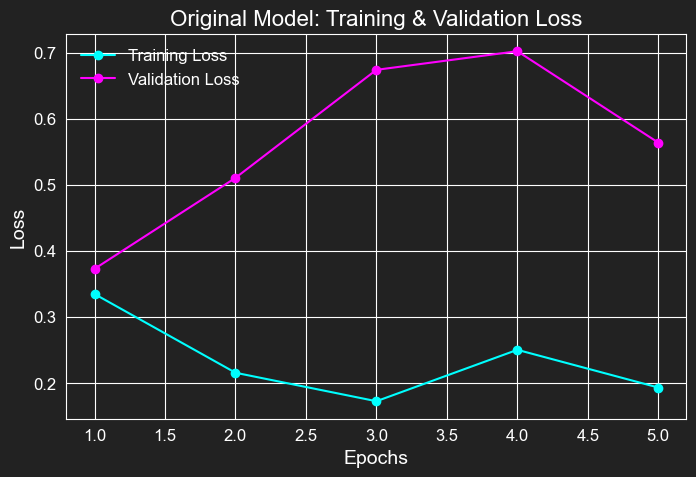

In [ ]:
# Extract the loss and validation loss from the history
loss = original_history.history['loss']
val_loss = original_history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss', color ='cyan')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', color = 'magenta')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Original Model: Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [7]:
def build_backbone():
    """
    Build a VGG16–based backbone that outputs an embedding.
    (Note: base layers are frozen.)
    """
    vgg = VGG16(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    embedding = Dense(128, activation='relu', name='embedding')(x)
    return Model(inputs=vgg.input, outputs=embedding, name='Backbone')

backbone_fsl = build_backbone()
backbone_fsl.summary()

Model: "Backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │     3,211,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,080 (68.38 MB)

 Trainable params: 3,211,392 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
def get_fresh_backbone():
    return build_backbone()

In [27]:
# -----------------------------------------------------------------------------
# 5c. Prototypical Networks
# -----------------------------------------------------------------------------

proto_backbone = get_fresh_backbone()


def prototypical_network_prediction(embedding_model, support_imgs, support_lbls, query_imgs, num_classes=NUM_CLASSES):
    support_embeddings = embedding_model(support_imgs)
    query_embeddings   = embedding_model(query_imgs)
    prototypes = []
    for c in range(num_classes):
        class_mask = tf.equal(tf.argmax(support_lbls, axis=1), c)
        class_embeddings = tf.boolean_mask(support_embeddings, class_mask)
        proto = tf.reduce_mean(class_embeddings, axis=0)
        prototypes.append(proto)
    prototypes = tf.stack(prototypes)  # shape: (num_classes, emb_dim)
    distances = tf.reduce_sum(tf.square(tf.expand_dims(query_embeddings, axis=1) - prototypes), axis=2)
    logits = -distances  # negative Euclidean distance
    predictions = tf.nn.softmax(logits, axis=1)
    return predictions

proto_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def proto_train_step(embedding_model, support_imgs, support_lbls, query_imgs, query_lbls):
    with tf.GradientTape() as tape:
        preds = prototypical_network_prediction(embedding_model, support_imgs, support_lbls, query_imgs)
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(query_lbls, preds))
    grads = tape.gradient(loss, embedding_model.trainable_variables)
    proto_optimizer.apply_gradients(zip(grads, embedding_model.trainable_variables))
    return loss

# Train Prototypical Networks episodically
proto_episodes = 8
print("\nTraining Prototypical Networks...")
t0 = time.time()
loss_history = []
for episode in range(proto_episodes):
    s_imgs, s_lbls, q_imgs, q_lbls = generate_episode(train_data)
    loss = proto_train_step(proto_backbone, s_imgs, s_lbls, q_imgs, q_lbls)
    loss_history.append(loss.numpy())
    if episode % 10 == 0:
        print(f"Prototypical Networks Episode {episode}: Loss = {loss.numpy():.4f}")
proto_training_time = time.time() - t0

def evaluate_proto(embedding_model, data, num_episodes=20):
    total_correct = 0
    total_samples = 0
    for _ in range(num_episodes):
        s_imgs, s_lbls, q_imgs, q_lbls = generate_episode(data)
        preds = prototypical_network_prediction(embedding_model, s_imgs, s_lbls, q_imgs)
        pred_classes = tf.argmax(preds, axis=1)
        true_classes = tf.argmax(q_lbls, axis=1)
        total_correct += np.sum(pred_classes.numpy() == true_classes.numpy())
        total_samples += q_imgs.shape[0]
    return total_correct / total_samples

proto_accuracy = evaluate_proto(proto_backbone, test_data)
print("Prototypical Networks Evaluation Accuracy:", proto_accuracy)

proto_backbone.save('models/proto_backbone.h5')
print("Saved proto_backbone.h5")


Training Prototypical Networks...
Prototypical Networks Episode 0: Loss = 0.4350


Prototypical Networks Evaluation Accuracy: 0.846875
Saved proto_backbone.h5


In [37]:
def evaluate_proto_detailed(embedding_model, data, num_episodes=20):
    """
    Evaluate the prototypical network on multiple episodes and
    return the list of episodic accuracies.
    """
    accuracies = []
    for _ in range(num_episodes):
        s_imgs, s_lbls, q_imgs, q_lbls = generate_episode(data)
        preds = prototypical_network_prediction(embedding_model, s_imgs, s_lbls, q_imgs)
        pred_classes = tf.argmax(preds, axis=1).numpy()
        true_classes = tf.argmax(q_lbls, axis=1).numpy()
        acc = np.sum(pred_classes == true_classes) / q_imgs.shape[0]
        accuracies.append(acc)
    return accuracies

# Evaluate over 20 episodes (you can adjust num_episodes as desired)
proto_accuracies = evaluate_proto_detailed(proto_backbone, test_data, num_episodes=25)
mean_acc = np.mean(proto_accuracies)
std_acc = np.std(proto_accuracies)
print(f"Aggregated Episodic Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Aggregated Episodic Accuracy: 0.8600 ± 0.0853


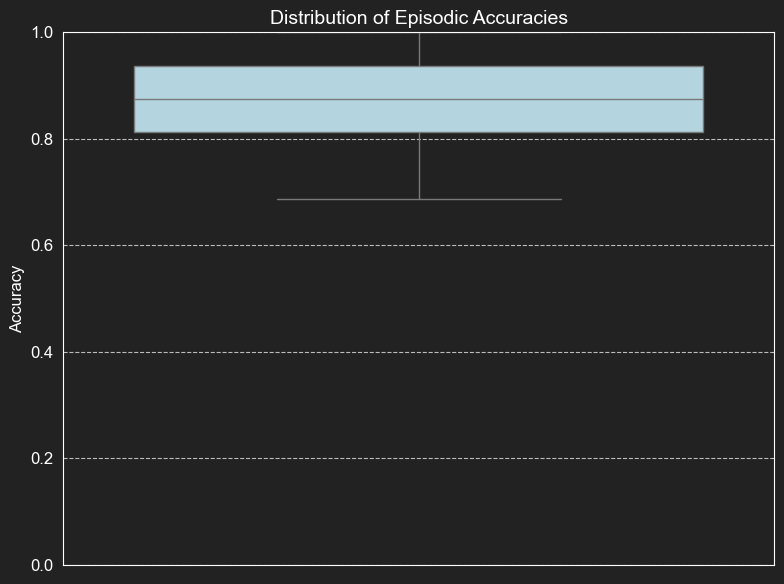

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=proto_accuracies, color='lightblue')
plt.title("Distribution of Episodic Accuracies", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


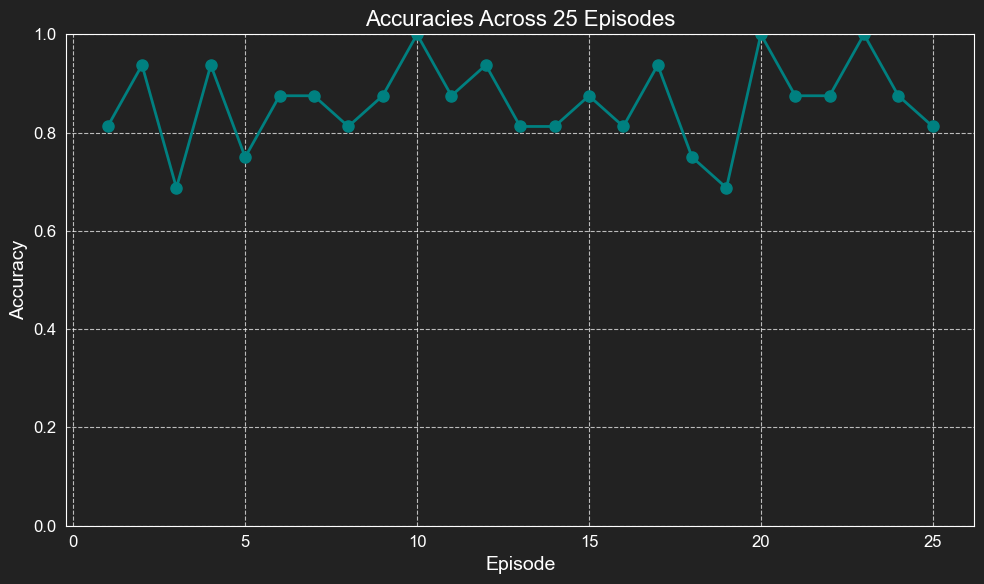

In [ ]:
episodes = np.arange(1, len(proto_accuracies)+1)

plt.figure(figsize=(10, 6))
plt.plot(episodes, proto_accuracies, 'o-', color='teal', linewidth=2, markersize=8)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracies Across 25 Episodes", fontsize=16)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [41]:
# -----------------------------------------------------------------------------
# 6. Comparative Results Summary
# -----------------------------------------------------------------------------
results = {
    "Original Model": {
        "Accuracy": original_eval[1],
        "Training Time (s)": original_training_time,
        "Confusion Matrix": cm_original,
        "Classification Report": report_original,
    },
    "Prototypical Networks": {
        "Accuracy": proto_accuracy,
        "Training Time (s)": proto_training_time,
    }
}

print("\n=== Comparative Results ===")
for method, metrics in results.items():
    print(f"\nMethod: {method}")
    for key, value in metrics.items():
        print(f"  {key}: {value}")


=== Comparative Results ===

Method: Original Model
  Accuracy: 0.8942307829856873
  Training Time (s): 1047.6687631607056
  Confusion Matrix: [[103 131]
 [155 235]]
  Classification Report:               precision    recall  f1-score   support

      NORMAL       0.40      0.44      0.42       234
   PNEUMONIA       0.64      0.60      0.62       390

    accuracy                           0.54       624
   macro avg       0.52      0.52      0.52       624
weighted avg       0.55      0.54      0.55       624


Method: Prototypical Networks
  Accuracy: 0.846875
  Training Time (s): 18.34032702445984


In [42]:
results = {
    "Original Model": {
        "Accuracy": original_eval[1],
        "Training Time (s)": original_training_time,
        "Confusion Matrix": str(cm_original),
        "Classification Report": report_original,
    },
    "Prototypical Networks": {
        "Accuracy": proto_accuracy,
        "Training Time (s)": proto_training_time,
    }
}

# Convert dictionary to DataFrame and export to CSV:
rows = []
for method, metrics in results.items():
    row = {"Method": method}
    for key, value in metrics.items():
        row[key] = value
    rows.append(row)

df = pd.DataFrame(rows)
csv_filename = "fsl_comparison_metrics.csv"
df.to_csv(csv_filename, index=False)
print(f"\nExported metrics to {csv_filename}")


Exported metrics to fsl_comparison_metrics.csv
